# Лабораторная работа №6 (Проведение исследований с моделями классификации)

## 1. Выбор начальных условий

### Обоснование выбора набора данных

Определение пола по изображению имеет важное применение в маркетинге и персонализации пользовательского опыта, а также в безопасности и аналитике. Модель, способная классифицировать пол по изображениям, может быть использована в системах безопасности для анализа видеопотоков и выявления подозрительных активностей. В маркетинговых исследованиях и рекламных технологиях такие модели помогают адаптировать контент под целевую аудиторию, улучшая пользовательский опыт и повышая эффективность рекламы. Также могут быть полезны в сфере розничной торговли для автоматического анализа клиентской базы, что позволяет персонализировать предложения и улучшить услуги.

### Выбор метрики

F1-Score: В реальных приложениях важно минимизировать ошибки обоих типов: отнесение изображений к неверному классу (ложные срабатывания) и упущение правильной классификации (ложные отрицания). F1-Score предоставляет сбалансированную оценку модели в таких условиях, так как объединяет в себе как точность (precision), так и полноту (recall). Она будет особенно актуальна в приложениях, где каждый неверный прогноз может привести к значительным последствиям — например, в безопасности или аналитике клиентских данных.

## 2.0 Подготовка данных

### Импорт библиотек
Импортируем основные библиотеки PyTorch и torchvision, которые будем использовать для обработки данных и создания модели.

In [52]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch import nn, optim
import kagglehub
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
import math
import torchvision.transforms as T
from torchvision.models import vit_b_16

Загружаем датасет

In [136]:
path = kagglehub.dataset_download("engrmwaqasniazi/mens-and-womens-images-for-fashion-classification")

Настройка путей и преобразований данных

In [137]:
train_dir = os.path.join(path, 'train')
valid_dir = os.path.join(path, 'valid')
test_dir = os.path.join(path, 'test')

# Преобразования для обучения и тестирования
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Загрузка данных и создание DataLoader

In [138]:
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


## 2.1 Обучение CNN

In [139]:
def train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        validation_preds = []
        validation_labels = []
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                validation_preds.extend(preds.cpu().numpy())
                validation_labels.extend(labels.cpu().numpy())

        validation_f1 = f1_score(validation_labels, validation_preds, average='weighted')

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Validation F1-score: {validation_f1}")

    return model

Опишем функции для визуализации результатов

In [ ]:
def imshow(ax, inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')

def visualize_model(model, dataloader, num_images=6):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    images_so_far = 0

    cols = 3
    rows = math.ceil(num_images / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(12, rows * 4))
    axs = axs.flatten()
    fig.tight_layout()

    female_images = 0
    male_images = 0
    class_names = ['Male', 'Female']

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if images_so_far == num_images:
                    return

                if female_images >= (num_images // 2 + num_images % 2)  and class_names[labels[j]] == 'Female':
                    continue
                if male_images >= num_images // 2 and class_names[labels[j]] == 'Male':
                    continue

                if class_names[labels[j]] == 'Female':
                    female_images += 1
                else:
                    male_images += 1

                ax = axs[images_so_far]

                title = f'Pred: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}'
                imshow(ax, inputs.cpu().data[j], title)

                images_so_far += 1

    plt.show()

In [141]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_features = resnet18.fc.in_features
resnet18.fc = torch.nn.Linear(num_features, 2)

In [142]:
# Параметры обучения
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

In [143]:
trained_model = train_model(resnet18, train_loader, valid_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5, Loss: 0.5299333069059584, Validation F1-score: 0.6649999999999998
Epoch 2/5, Loss: 0.4099778952421965, Validation F1-score: 0.8175478384124735
Epoch 3/5, Loss: 0.4021445998439082, Validation F1-score: 0.8732499999999999
Epoch 4/5, Loss: 0.3326880865626865, Validation F1-score: 0.861159420289855
Epoch 5/5, Loss: 0.3230479343069924, Validation F1-score: 0.8539047619047619


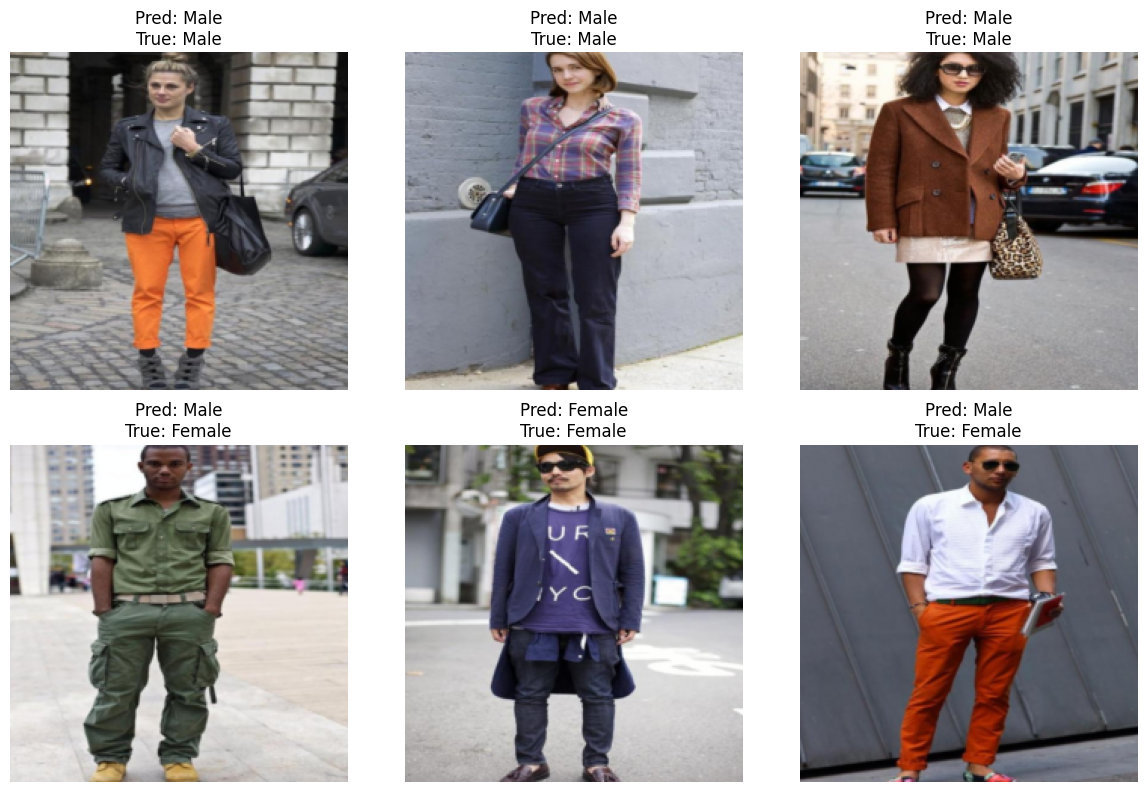

In [144]:
visualize_model(resnet18, test_loader, num_images=6)

В целом модель достаточно не плохо справляется с определение пола по изображению. Особенно если учесть особенность датасета, дело в том, что автор перепутал значения слов male и female, поэтому стоит учитывать что здесь female это мужчина

## 2.2 Улучшенный бейзлайн CNN

Для улучшения показателей модели попробуем предположить, что аугментация данных может помочь.  Для этого опишем функцию преобраования данных, а именно будем удалять случайное место на картинке. Это может помочь, так как чаще всего будет удаляться часть фона, которая может скорее только отвлекать модель, от основного образа человека

In [145]:
cj_re_tfms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    T.RandomErasing(p=0.8, scale=(0.02,0.15))
])
train_impr_data = datasets.ImageFolder(train_dir, transform=cj_re_tfms)
valid_impr_data = datasets.ImageFolder(valid_dir, transform=cj_re_tfms)

train_impr_loader = DataLoader(train_impr_data, batch_size=32, shuffle=True)
valid_impr_loader = DataLoader(valid_impr_data, batch_size=32, shuffle=False)

In [146]:
trained_model = train_model(resnet18, train_impr_loader, valid_impr_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5, Loss: 0.23445062146142678, Validation F1-score: 0.7496767466110532
Epoch 2/5, Loss: 0.16522476904922062, Validation F1-score: 0.7920039682539682
Epoch 3/5, Loss: 0.11380694661703375, Validation F1-score: 0.5683738280068555
Epoch 4/5, Loss: 0.09145250012753187, Validation F1-score: 0.8203664821530827
Epoch 5/5, Loss: 0.056367372869755385, Validation F1-score: 0.8203664821530827


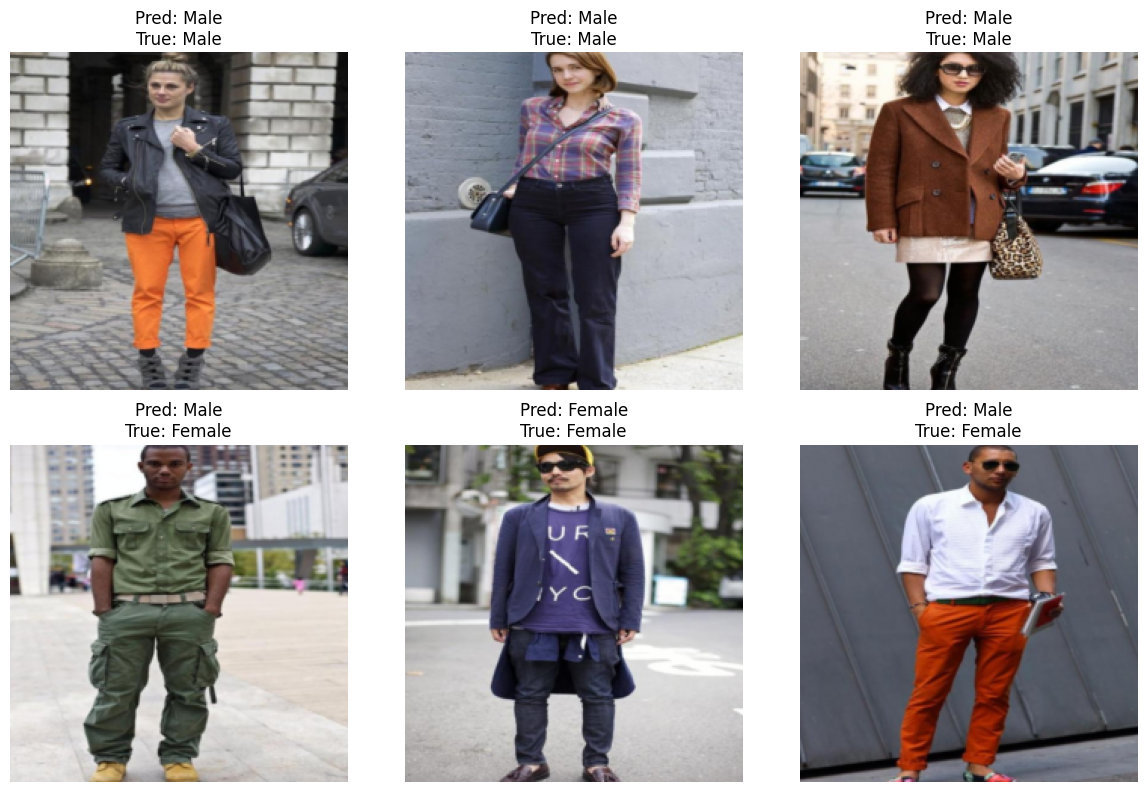

In [147]:
visualize_model(resnet18, test_loader, num_images=6)

Гипотеза не подтвердилась, и по метрике f1-score точность немного ухудшилась

## 2.3 Собственная имплементация CNN

Напишем свою реализацию модели

In [148]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc = nn.Linear(64 * 28 * 28, num_classes)
    def forward(self, x):
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))
        x = self.pool(nn.ReLU()(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [149]:
custom_cnn = SimpleCNN()
custom_optimizer = torch.optim.Adam(custom_cnn.parameters(), lr=1e-4)

In [150]:
trained_custom_cnn = train_model(custom_cnn, train_loader, valid_loader, criterion, custom_optimizer, num_epochs=5)

Epoch 1/5, Loss: 0.6349657818123147, Validation F1-score: 0.6699435028248587
Epoch 2/5, Loss: 0.5285943150520325, Validation F1-score: 0.7237362637362638
Epoch 3/5, Loss: 0.5422820250193278, Validation F1-score: 0.6959486571027936
Epoch 4/5, Loss: 0.5317787241052698, Validation F1-score: 0.7774154494012371
Epoch 5/5, Loss: 0.563638241202743, Validation F1-score: 0.7560784313725489


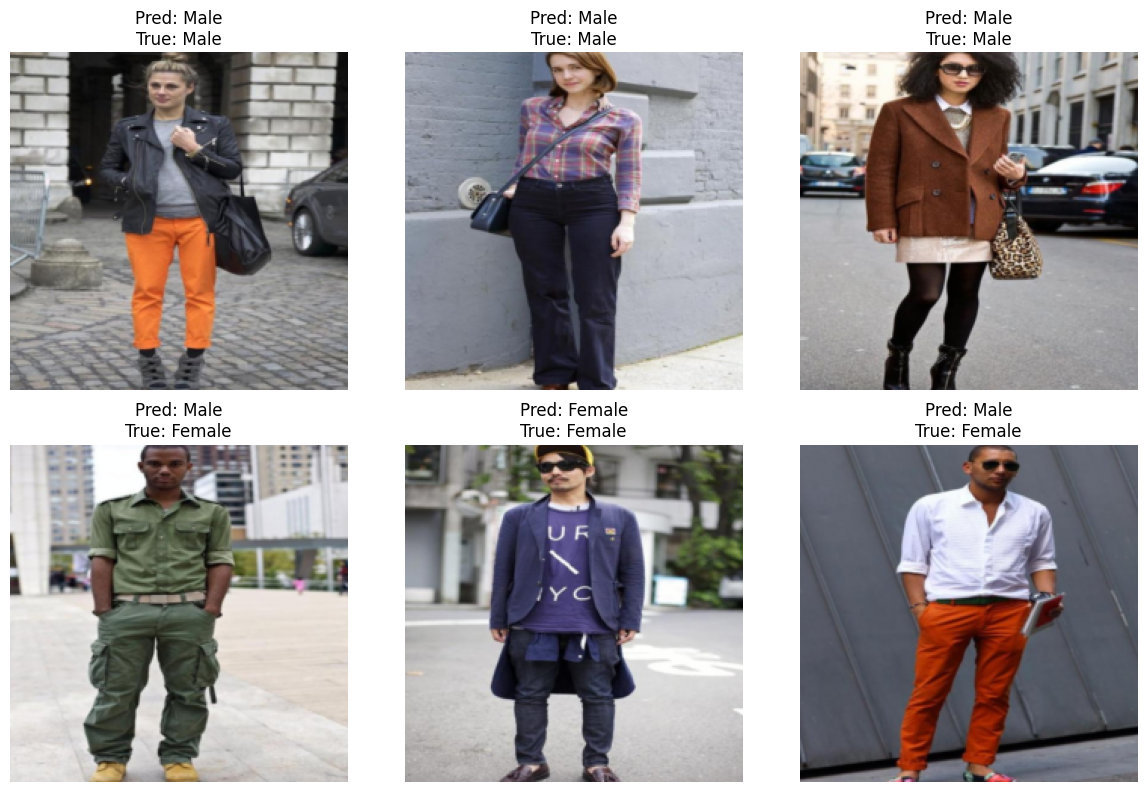

In [151]:
visualize_model(trained_custom_cnn, test_loader, num_images=6)

точность модели получилась несколько хуже библиотечного варианта, попробуем применить тот же подход с аугментацией данных для улучшения качества предсказаний

## 2.4 Улучшенный бейзлайн собственной имплементаци CNN

In [152]:
trained_impr_custom_cnn = train_model(custom_cnn, train_impr_loader, valid_impr_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 0.41205102757171347, Validation F1-score: 0.7388868723532971
Epoch 2/10, Loss: 0.419258118779571, Validation F1-score: 0.7388868723532971
Epoch 3/10, Loss: 0.4172225622115312, Validation F1-score: 0.7560784313725489
Epoch 4/10, Loss: 0.4155179080035951, Validation F1-score: 0.7276429030186254
Epoch 5/10, Loss: 0.41586419112152523, Validation F1-score: 0.7461794019933555
Epoch 6/10, Loss: 0.4021892779403263, Validation F1-score: 0.720797342192691
Epoch 7/10, Loss: 0.40940095097930346, Validation F1-score: 0.7461794019933555
Epoch 8/10, Loss: 0.41432397233115303, Validation F1-score: 0.7345711759504863
Epoch 9/10, Loss: 0.41789824543175874, Validation F1-score: 0.7388868723532971
Epoch 10/10, Loss: 0.4091340805645342, Validation F1-score: 0.7461794019933555


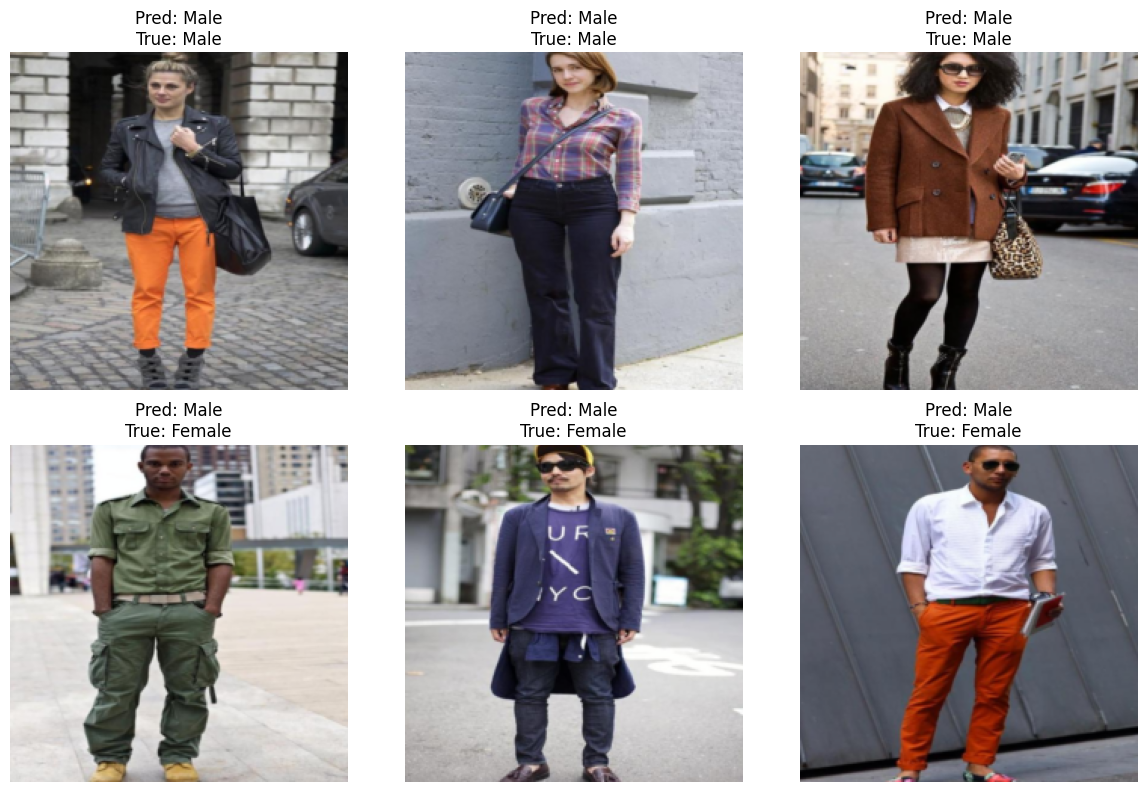

In [153]:
visualize_model(trained_impr_custom_cnn, test_loader, num_images=6)

Увы, но и в данном случае, такое преобразование картинок не помогло моделе стать лучше. Вероятно более хорошим вариантом было бы обрезать фон, или применять к нему блюр, чтобы модель человека была более ярко выраженой на изображении. Так же можно попробовать применять различные фильтры, чтобы улучшить качество изображения.

## 2.5 Обучение трансформера

In [166]:
vit = vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
vit.heads.head = nn.Linear(vit.heads.head.in_features, 2)

In [167]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=0.001)

In [169]:
trained_vit = train_model(vit, train_loader, valid_loader, criterion, optimizer, num_epochs=2)

Epoch 1/2, Loss: 0.500887562279348, Validation F1-score: 0.6699435028248587
Epoch 2/2, Loss: 0.5058500711564664, Validation F1-score: 0.6699435028248587


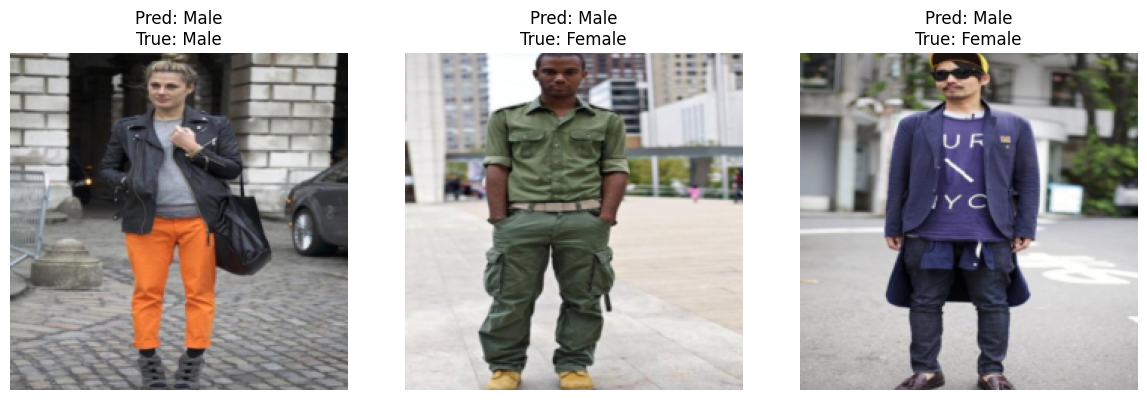

In [157]:
visualize_model(vit, test_loader, num_images=3)

Судя по значению f1-score для модели не хватает данных для обучения. Выглядит так, что модель выбирает стратегию всегда отвечать male, что так же может быть причиной классовой несбалансированности в данных

## 2.6 Улучшенный бейзлайн обучения трансформера

In [170]:
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.1, contrast=0.5, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Загрузка обучающих и валидационных наборов данных
train_impr_data = datasets.ImageFolder(train_dir, transform=transform)
valid_impr_data = datasets.ImageFolder(valid_dir, transform=transform)

# Создание загрузчиков данных
train_impr_loader = DataLoader(train_impr_data, batch_size=32, shuffle=True)
valid_impr_loader = DataLoader(valid_impr_data, batch_size=32, shuffle=False)

In [171]:
trained_vit = train_model(vit, train_impr_loader, valid_impr_loader, criterion, optimizer, num_epochs=2)

Epoch 1/2, Loss: 0.5064667165279388, Validation F1-score: 0.6699435028248587
Epoch 2/2, Loss: 0.49048612515131634, Validation F1-score: 0.6699435028248587


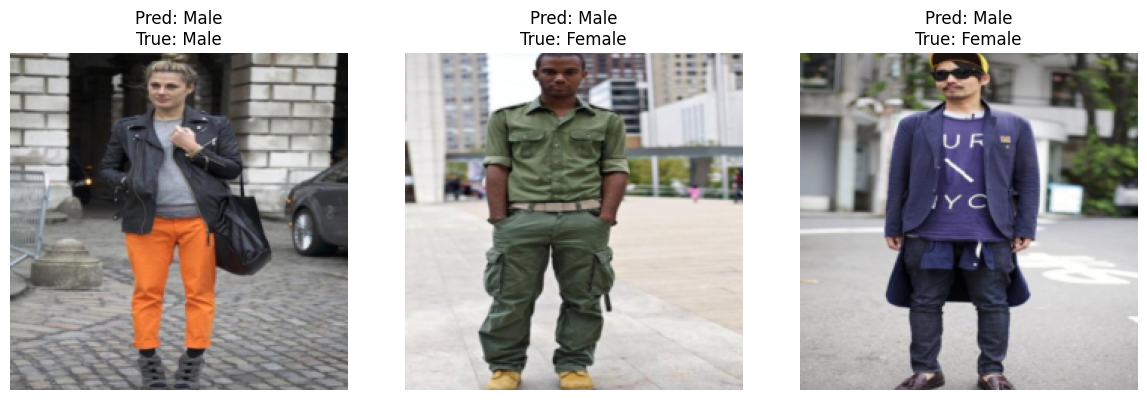

In [172]:
visualize_model(vit, test_loader, num_images=3)

## 2.7 Собственная имплементация обучения транформера

опишим свой аналог для библиотечной реализации

In [ ]:
class SimpleViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, emb_dim=128, depth=6, n_heads=8, mlp_ratio=4, num_classes=2):
        super(SimpleViT, self).__init__()
        assert img_size % patch_size == 0, "Image dimensions must be divisible by the patch size."
        self.patch_size = patch_size
        num_patches = (img_size // patch_size) ** 2

        self.patch_embed = nn.Conv2d(3, emb_dim, kernel_size=patch_size, stride=patch_size)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches+1, emb_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=n_heads,
                                                   dim_feedforward=emb_dim * mlp_ratio, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.head = nn.Linear(emb_dim, num_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1,2)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        x = x + self.pos_embed

        x = self.transformer(x)

        cls_out = x[:,0]
        return self.head(cls_out)

In [173]:
vit_base = SimpleViT()

In [174]:
vit_base_trained = train_model(vit, train_loader, valid_loader, criterion, optimizer, num_epochs=2)

Epoch 1/2, Loss: 0.49147331714630127, Validation F1-score: 0.7241551288916087
Epoch 2/2, Loss: 0.5033572713534037, Validation F1-score: 0.7241551288916087


снова получаем результат с одной стратегией, что доказывает неприменимость даного типа моделей с  выбранным датасетом. Требуется его дополнительная предобработка, либо изменения архитектуры модели с подбором гиперпараметров

## 2.8 Собственная имплементация обучения транформера

In [175]:
vit_impr_trained = train_model(vit, train_impr_loader, valid_impr_loader, criterion, optimizer, num_epochs=2)

Epoch 1/2, Loss: 0.5040148364173042, Validation F1-score: 0.6699435028248587
Epoch 2/2, Loss: 0.4836137647981997, Validation F1-score: 0.6699435028248587


# Итоговые результаты

| Модель                   | F1-score |
|--------------------------|--------|
| CNN                      | 0.8539 |
| CNN improved             | 0.8203 |
| Custom CNN               | 0.7567 |
| Custom CNN improved      | 0.7461 |
| vit_b_16                 | 0.6699 |
| vit_b_16 improved        | 0.6699 |
| Custom vit_b_16          | 0.7241 |
| Custom vit_b_16 improved | 0.6699 |

# Заключение

Анализируя значения F1-score, можно заключить, что модели могли недостаточно обучиться из-за ограничения данных. Это приводит к вероятности того, что модели выбирают стратегию предсказания наиболее частого класса, что указывает на потенциальную несбалансированность классов в обучающем наборе данных.

Стандартная модель CNN показала лучший результат среди всех протестированных подходов, что подтверждает её эффективность на данном наборе данных. Модели на базе ViT (Vision Transformer) продемонстрировали стабильные, но более низкие результаты, что может указывать на необходимость больше внимания к специализированной настройке или увеличению тренировочного набора изображений для таких архитектур.

Для улучшения метрик в будущем рекомендуется:

1. Увеличить объём обучающего набора данных.
2. Применить методы балансировки классов, такие как oversampling или class weights.
3. Исследовать возможности для дальнейшей оптимизации моделей и гиперпараметров.